In [1]:
import Pkg
using Pkg

Pkg.add("Random")
Pkg.add("Flux")
Pkg.add("MLJFlux")
Pkg.add("Plots")
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("MLJ")
Pkg.add("MLJScikitLearnInterface")
Pkg.add("MLDataUtils")
Pkg.add("GLM")
Pkg.add("PrettyTables")

using Random, Flux, MLJFlux, Plots, CSV, DataFrames, MLJ, MLJScikitLearnInterface, MLDataUtils, GLM, PrettyTables

Random.seed!(123)

   Resolving package versions...
  No Changes to `C:\Users\buser\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\buser\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\buser\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\buser\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\buser\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\buser\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\buser\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\buser\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\buser\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\buser\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\buser\.julia\environments\v1.11\Project.toml`
  No 

TaskLocalRNG()

# Question 1 - NN Basics

## I. Fitting Data

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(1 => 50, logistic)  # 100 parameters
│   summary(x) = "1×500 Matrix{Float64}"
└ @ Flux C:\Users\buser\.julia\packages\Flux\uRn8o\src\layers\stateless.jl:60


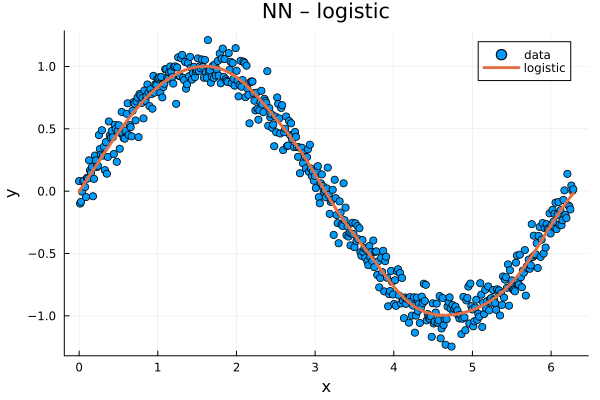

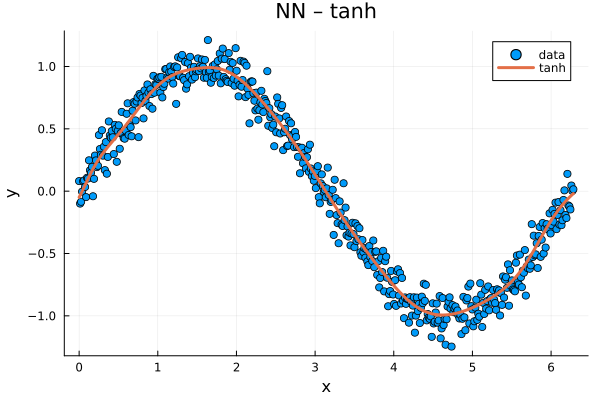

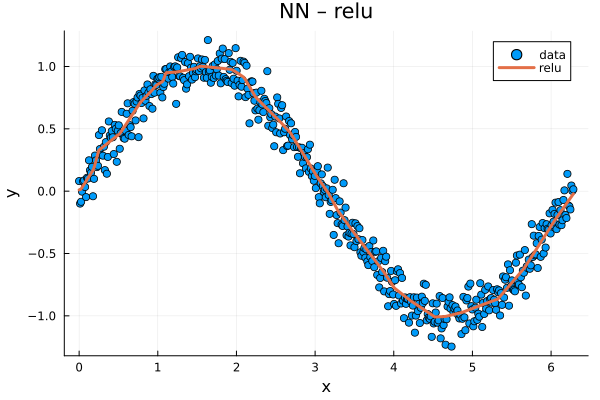

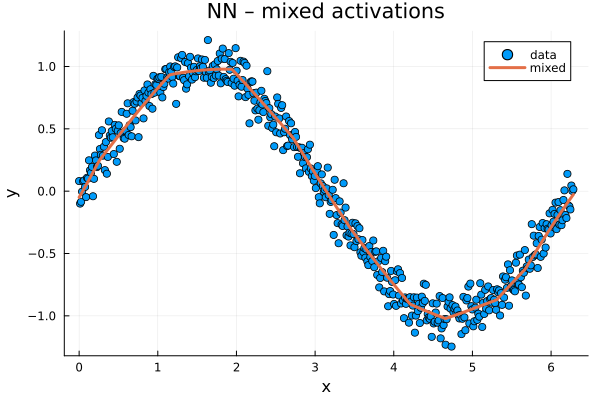

MSE logistic = 0.009904299687005057
MSE tanh     = 0.009911992640796476
MSE relu     = 0.00974425984572379
MSE mixed    = 0.009905232630079305


In [4]:
x = collect(range(0, stop = 2*pi; length=500))
y = sin.(x) .+ 0.1*randn(500)
X = reshape(x, 1, :)
Y = reshape(y, 1, :)

logistic(z) = 1 ./ (1 .+ exp.(-z))
tanh_act(z) = tanh.(z)
relu_act(z) = max.(z, 0)

loss(m, x, y) = Flux.Losses.mse(m(x), y)

function train_nn(X, Y; activation, lr = 0.01, epochs = 5000)
    model = Chain(
        Dense(1, 50, activation),
        Dense(50, 50, activation),
        Dense(50, 50, activation),
        Dense(50, 1)
    )
    opt = Flux.setup(Adam(lr), model)
    for _ in 1:epochs
        gs = gradient(m -> loss(m, X, Y), model)
        Flux.update!(opt, model, gs[1])
    end
    return model
end

model_logistic = train_nn(X, Y; activation = logistic)
model_tanh     = train_nn(X, Y; activation = tanh_act)
model_relu     = train_nn(X, Y; activation = relu_act)

yhat_log  = vec(model_logistic(X))
yhat_tanh = vec(model_tanh(X))
yhat_relu = vec(model_relu(X))

model_mixed = Chain(
    Dense(1, 50, logistic),
    Dense(50, 50, tanh_act),
    Dense(50, 50, relu_act),
    Dense(50, 1)
)

opt_mixed = Flux.setup(Adam(0.01), model_mixed)
for _ in 1:5000
    gs = gradient(m -> loss(m, X, Y), model_mixed)
    Flux.update!(opt_mixed, model_mixed, gs[1])
end

yhat_mixed = vec(model_mixed(X))

p1 = scatter(x, y, label = "data", xlabel = "x", ylabel = "y",
             title = "NN – logistic")
plot!(p1, x, yhat_log, label = "logistic",linewidth = 3)
display(p1)

p2 = scatter(x, y, label = "data", xlabel = "x", ylabel = "y",
             title = "NN – tanh")
plot!(p2, x, yhat_tanh, label = "tanh",linewidth = 3)
display(p2)

p3 = scatter(x, y, label = "data", xlabel = "x", ylabel = "y",
             title = "NN – relu")
plot!(p3, x, yhat_relu, label = "relu",linewidth = 3)
display(p3)

p4 = scatter(x, y, label = "data", xlabel = "x", ylabel = "y",
             title = "NN – mixed activations")
plot!(p4, x, yhat_mixed, label = "mixed", linewidth = 3)
display(p4)

mse_log  = loss(model_logistic, X, Y)
mse_tanh = loss(model_tanh, X, Y)
mse_relu = loss(model_relu, X, Y)
mse_mixed = loss(model_mixed, X, Y)

println("MSE logistic = ", mse_log)
println("MSE tanh     = ", mse_tanh)
println("MSE relu     = ", mse_relu)
println("MSE mixed    = ", mse_mixed)


As the network becomes deeper, the model becomes much more sensitive to the learning rate: larger learning rates quickly destabilize training, while small learning rates (especially 0.001) remain stable and produce good fits. Thus, deeper networks require smaller learning rates to train reliably.

## II. Learning Rates

The learning rate is the step size taken by the algorithm in the gradient direction after updating the weights, it controls how fast the neural network learns.

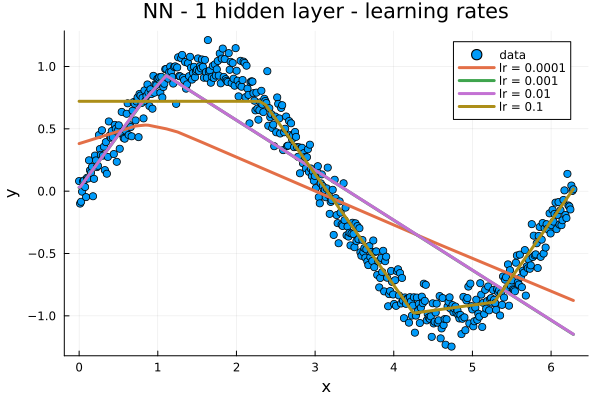

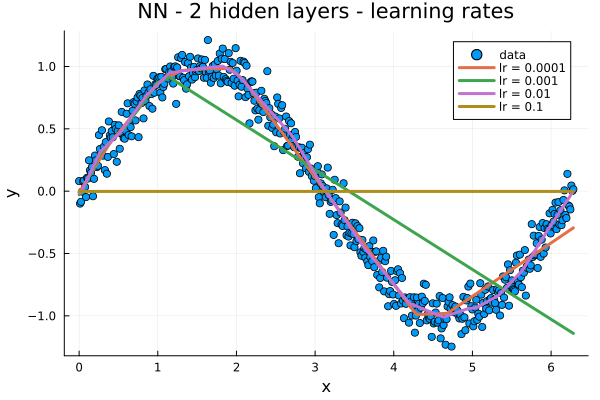

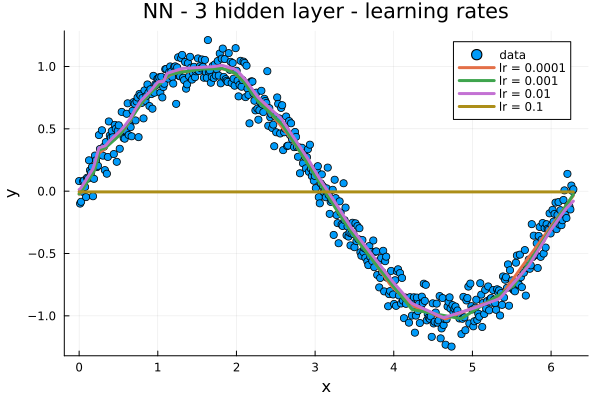

In [7]:
lrs = [0.0001, 0.001, 0.01, 0.1]
best_activation = relu_act

function train_nn_layers(X, Y; activation, lr = 0.01, epochs = 3000, hidden_layers = 1)
    layers = Any[Dense(1, 50, activation)]
    for _ in 2:hidden_layers
        push!(layers, Dense(50, 50, activation))
    end
    push!(layers, Dense(50, 1))
    model = Chain(layers...)
    opt = Flux.setup(Adam(lr), model)
    for _ in 1:epochs
        gs = gradient(m -> loss(m, X, Y), model)
        Flux.update!(opt, model, gs[1])
    end
    return model
end

p_lr1 = scatter(x, y, label = "data", xlabel = "x", ylabel = "y",
                title = "NN - 1 hidden layer - learning rates")
for lr in lrs
    m = train_nn_layers(X, Y; activation = best_activation,
                        lr = lr, epochs = 5000, hidden_layers = 1)
    yhat = vec(m(X))
    plot!(p_lr1, x, yhat, label = "lr = $(lr)", linewidth = 3)
end
display(p_lr1)

# 2 hidden layers (50 neuronas c/u)
p_lr2 = scatter(x, y, label = "data", xlabel = "x", ylabel = "y",
                title = "NN - 2 hidden layers - learning rates")
for lr in lrs
    m = train_nn_layers(X, Y; activation = best_activation,
                        lr = lr, epochs = 5000, hidden_layers = 2)
    yhat = vec(m(X))
    plot!(p_lr2, x, yhat, label = "lr = $(lr)", linewidth = 3)
end
display(p_lr2)

# 3 hidden layers (50 neuronas c/u)
p_lr3 = scatter(x, y, label = "data", xlabel = "x", ylabel = "y",
                title = "NN - 3 hidden layer - learning rates")
for lr in lrs
    m = train_nn_layers(X, Y; activation = best_activation,
                        lr = lr, epochs = 5000, hidden_layers = 3)
    yhat = vec(m(X))
    plot!(p_lr3, x, yhat, label = "lr = $(lr)", linewidth = 3)
end
display(p_lr3)

The higher the numbers of hidden layers, 

# Question 2 - DML

## I. Cleaning and set-up

In [10]:
url = "https://raw.githubusercontent.com/VC2015/DMLonGitHub/master/penn_jae.dat"
download(url, "penn_jae.dat")
df = CSV.read("penn_jae.dat", DataFrame; ignorerepeated = true, delim = ' ')

df = df[(df.tg .== 0) .| (df.tg .== 4), :]

df.T4 = Int.(df.tg .== 4)
df.y = log.(df.inuidur1)

df.dep_1 = Int.(df.dep .== 1)
df.dep_2 = Int.(df.dep .== 2)

x = select(df,
    :female, :black, :othrace,
    :dep_1, :dep_2,
    :q2, :q3, :q4, :q5, :q6,
    :recall, :agelt35, :agegt54,
    :durable, :nondurable, :lusd, :husd
)

d = df.T4
y = df.y

5099-element Vector{Float64}:
 2.8903717578961645
 0.0
 3.295836866004329
 2.1972245773362196
 3.295836866004329
 3.295836866004329
 2.1972245773362196
 3.295836866004329
 2.70805020110221
 3.332204510175204
 2.4849066497880004
 3.091042453358316
 2.8903717578961645
 ⋮
 3.295836866004329
 2.70805020110221
 2.995732273553991
 0.0
 3.1354942159291497
 2.5649493574615367
 1.791759469228055
 2.302585092994046
 1.3862943611198906
 2.1972245773362196
 1.3862943611198906
 3.295836866004329

In [11]:
function training_sample_append(cv_split, test_sample_index)
    training_indices = []
    for v in cv_split[Not(test_sample_index)]
        training_indices = [training_indices; v]
    end
    return training_indices, cv_split[test_sample_index]
end

function dml(x, d, y, dreg, yreg, nfold)
    n = length(y)
    cv = [partition(eachindex(y),
                    fill(1/nfold, nfold - 1)...,
                    shuffle = true, rng = 1234)...]
    machine_y = machine(yreg, x, y, scitype_check_level = 0)
    machine_d = machine(dreg, x, d, scitype_check_level = 0)
    y_hat = zeros(n)
    d_hat = zeros(n)
    for fold in 1:nfold
        train_idx, test_idx = training_sample_append(cv, fold)
        fit!(machine_y, rows = train_idx)
        fit!(machine_d, rows = train_idx)
        y_hat[test_idx] = MLJ.predict(machine_y, rows = test_idx)
        d_hat[test_idx] = MLJ.predict(machine_d, rows = test_idx)
    end
    resy = y .- y_hat
    resd = d .- d_hat
    X = reshape(resd, :, 1)
    est = lm(X, resy)
    beta = GLM.coef(est)[1]
    se = GLM.coeftable(est).cols[2][1]
    return beta, se, resy, resd
end

function summarize(beta, se, resy, resd, name)
    DataFrame(
        model = [name],
        estimate = [beta],
        stderr = [se],
        rmse_y = [sqrt(mean(resy.^2))],
        rmse_d = [sqrt(mean(resd.^2))]
    )
end

LinearRegressor = @load LinearRegressor pkg=MLJScikitLearnInterface verbosity=0
LassoCVRegressor = @load LassoCVRegressor pkg=MLJScikitLearnInterface verbosity=0
RandomForestRegressor = @load RandomForestRegressor pkg=MLJScikitLearnInterface verbosity=0
NeuralNetworkRegressor = @load NeuralNetworkRegressor pkg=MLJFlux verbosity=0

dreg = Standardizer() |> LinearRegressor()
yreg = Standardizer() |> LinearRegressor()
res_ols = dml(x, d, y, dreg, yreg, 10)
tab_ols = summarize(res_ols..., "OLS")

dreg = Standardizer() |> LassoCVRegressor(max_iter = 200000)
yreg = Standardizer() |> LassoCVRegressor(max_iter = 200000)
res_lasso = dml(x, d, y, dreg, yreg, 10)
tab_lasso = summarize(res_lasso..., "LassoCV")

dreg = RandomForestRegressor()
yreg = RandomForestRegressor()
res_rf = dml(x, d, y, dreg, yreg, 10)
tab_rf = summarize(res_rf..., "RF")

nn_model = NeuralNetworkRegressor(
    builder = MLJFlux.MLP(; hidden = (20,20), σ = relu),
    epochs = 100,
    batch_size = 32,
    optimiser = Flux.ADAM(0.001),
    rng = 1234
)
dreg = Standardizer() |> nn_model
yreg = Standardizer() |> nn_model
res_nn = dml(x, d, y, dreg, yreg, 10)
tab_nn = summarize(res_nn..., "NeuralNet")

table_cf = vcat(tab_ols, tab_lasso, tab_rf, tab_nn)
pretty_table(table_cf)

[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
┌ Warning: No features to standarize.
└ @ MLJModels C:\Users\buser\.julia\packages\MLJModels\ziReN\src\builtins\Transformers.jl:637
[ Info: Training machine(:linear_regressor, …).
[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
┌ Warning: No features to standarize.
└ @ MLJModels C:\Users\buser\.julia\packages\MLJModels\ziReN\src\builtins\Transformers.jl:637
[ Info: Training machine(:linear_regressor, …).
[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
┌ Warning: No features to standarize.
└ @ MLJModels C:\Users\buser\.julia\packages\MLJModels\ziReN\src\builtins\Transformers.jl:637
[ Info: Training machine(:linear_regressor, …).
[ In

┌───────────┬────────────┬───────────┬─────────┬──────────┐
│     model │   estimate │    stderr │  rmse_y │   rmse_d │
│    String │    Float64 │   Float64 │ Float64 │  Float64 │
├───────────┼────────────┼───────────┼─────────┼──────────┤
│       OLS │  -0.069807 │ 0.0352299 │ 1.19593 │ 0.475255 │
│   LassoCV │ -0.0729707 │ 0.0352817 │ 1.19601 │ 0.474574 │
│        RF │ -0.0943331 │  0.034889 │ 1.26746 │ 0.508433 │
│ NeuralNet │ -0.0739467 │ 0.0345703 │ 1.21608 │ 0.492451 │
└───────────┴────────────┴───────────┴─────────┴──────────┘


In [22]:
# Selected model: Lasso
total_rmse = table_cf.rmse_y .+ table_cf.rmse_d
best_idx = argmin(total_rmse)

best_model_df = table_cf[best_idx:best_idx, :]  # sigue siendo DataFrame
println("\nBest model based on rmse_y + rmse_d:")
pretty_table(best_model_df)


Best model based on rmse_y + rmse_d:
┌─────────┬────────────┬───────────┬─────────┬──────────┐
│   model │   estimate │    stderr │  rmse_y │   rmse_d │
│  String │    Float64 │   Float64 │ Float64 │  Float64 │
├─────────┼────────────┼───────────┼─────────┼──────────┤
│ LassoCV │ -0.0729707 │ 0.0352817 │ 1.19601 │ 0.474574 │
└─────────┴────────────┴───────────┴─────────┴──────────┘


In [12]:
function dml_nocf(x, d, y, dreg, yreg)
    n = length(y)
    machine_y = machine(yreg, x, y, scitype_check_level = 0)
    machine_d = machine(dreg, x, d, scitype_check_level = 0)
    fit!(machine_y)
    fit!(machine_d)
    y_hat = MLJ.predict(machine_y, x)
    d_hat = MLJ.predict(machine_d, x)
    resy = y .- y_hat
    resd = d .- d_hat
    resy64 = Float64.(resy)
    resd64 = Float64.(resd)
    X = reshape(resd64, :, 1)
    est = lm(X, resy64)
    beta = GLM.coef(est)[1]
    se = GLM.coeftable(est).cols[2][1]

    return beta, se, resy, resd
end

dreg = Standardizer() |> LinearRegressor()
yreg = Standardizer() |> LinearRegressor()
res_ols_nc = dml_nocf(x, d, y, dreg, yreg)
tab_ols_nc = summarize(res_ols_nc..., "OLS_nocf")

dreg = Standardizer() |> LassoCVRegressor(max_iter = 200000)
yreg = Standardizer() |> LassoCVRegressor(max_iter = 200000)
res_lasso_nc = dml_nocf(x, d, y, dreg, yreg)
tab_lasso_nc = summarize(res_lasso_nc..., "LassoCV_nocf")

dreg = RandomForestRegressor()
yreg = RandomForestRegressor()
res_rf_nc = dml_nocf(x, d, y, dreg, yreg)
tab_rf_nc = summarize(res_rf_nc..., "RF_nocf")

dreg = Standardizer() |> nn_model
yreg = Standardizer() |> nn_model
res_nn_nc = dml_nocf(x, d, y, dreg, yreg)
tab_nn_nc = summarize(res_nn_nc..., "NeuralNet_nocf")

table_nocf = vcat(tab_ols_nc, tab_lasso_nc, tab_rf_nc, tab_nn_nc)
pretty_table(table_nocf)

[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
┌ Warning: No features to standarize.
└ @ MLJModels C:\Users\buser\.julia\packages\MLJModels\ziReN\src\builtins\Transformers.jl:637
[ Info: Training machine(:linear_regressor, …).
[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
┌ Warning: No features to standarize.
└ @ MLJModels C:\Users\buser\.julia\packages\MLJModels\ziReN\src\builtins\Transformers.jl:637
[ Info: Training machine(:linear_regressor, …).
[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
┌ Warning: No features to standarize.
└ @ MLJModels C:\Users\buser\.julia\packages\MLJModels\ziReN\src\builtins\Transformers.jl:637
[ Info: Training machine(:lasso_cv_regressor, …).
[ 

┌────────────────┬────────────┬───────────┬─────────┬──────────┐
│          model │   estimate │    stderr │  rmse_y │   rmse_d │
│         String │    Float64 │   Float64 │ Float64 │  Float64 │
├────────────────┼────────────┼───────────┼─────────┼──────────┤
│       OLS_nocf │ -0.0725756 │ 0.0352081 │ 1.19047 │ 0.473365 │
│   LassoCV_nocf │ -0.0728532 │ 0.0351679 │ 1.19052 │ 0.473923 │
│        RF_nocf │ -0.0813103 │  0.035238 │ 1.07702 │ 0.427844 │
│ NeuralNet_nocf │  -0.081031 │ 0.0352697 │ 1.14453 │ 0.454254 │
└────────────────┴────────────┴───────────┴─────────┴──────────┘


In [24]:
# Selected model: RF
total_rmse = table_nocf.rmse_y .+ table_nocf.rmse_d
best_idx = argmin(total_rmse)

best_model_df = table_nocf[best_idx:best_idx, :]  # sigue siendo DataFrame
println("\nBest model based on rmse_y + rmse_d:")
pretty_table(best_model_df)


Best model based on rmse_y + rmse_d:
┌─────────┬────────────┬──────────┬─────────┬──────────┐
│   model │   estimate │   stderr │  rmse_y │   rmse_d │
│  String │    Float64 │  Float64 │ Float64 │  Float64 │
├─────────┼────────────┼──────────┼─────────┼──────────┤
│ RF_nocf │ -0.0813103 │ 0.035238 │ 1.07702 │ 0.427844 │
└─────────┴────────────┴──────────┴─────────┴──────────┘


1. What can you say about the RMSE for predicting y and d?

The RMSE is sistematically lower without cross-fitting. The reduction in RMSE is particularly higher for more flexible models, such as Random Forest (y: 1,27 -> 1,08 / d: 0,51 -> 0,43) or Neural Network (y: 1,22 -> 1,14 / d: 0,49 -> 0,45), whereas it's negligible for OLS and Lasso.

2. Why is it that estimating with one function yields lower RMSE than another?

Even though models like RF and NN are able to capture more complex relations, the overfitting risk is also higher. That is why when subjected to cross-fitting, they may not perform well since the RMSE is measured out-of-sample, thus the simpler models yield a lower RMSE in comparison. Without cross-fitting, the RMSE is in-sample and it is noticeable that now RF and NN perform so much better. All in all, depends on both the model and wheter there is cross-fitting or not.

3. What problem would we have if we chose to estimate without cross-fitting?

Estimating without cross-fitting yields artificially low RMSE because the models overfit and are evaluated on the same data they were trained on. This breaks the orthogonality required by DML and leads to biased estimates with overly optimistic standard errors.
